In [36]:
import pandas as pd
import json
import logging
from prophet import Prophet
from hyperopt import space_eval
from hyperopt import hp, fmin, tpe, Trials
from sklearn.metrics import mean_squared_error
logging.getLogger("cmdstanpy").setLevel(logging.ERROR)

In [37]:
df = pd.read_csv('products.csv')
# drop NoPromo_Units NoPromo_Dollars IncUnits IncDollars
df = df.drop(['NoPromo_Units', 'NoPromo_Dollars', 'IncUnits', 'IncDollars', 'GLMarket'], axis=1)
# remove w in GLPeriod values
df['GLPeriod'] = df['GLPeriod'].str.replace('w', '')
df['GLPeriod'] = pd.to_datetime(df['GLPeriod'], format='%Y%m%d')
df.dropna(inplace=True)
df = df.rename(columns={'GLPeriod': 'Date'})
df.head()

,UPC,Date,Dollars,BaseDollars,Units,Base_Units,AnyPromo_Dollars,AnyPromo_Units
0,89231600047,2019-01-05,0.00,3.84,0.0,0.148,0.0,0.0
1,9950010526,2019-01-19,0.00,0.66,0.0,0.349,0.0,0.0
2,7780253340,2019-01-26,0.00,0.23,0.0,0.120,0.0,0.0
3,6197200193,2019-02-16,0.00,1.63,0.0,1.054,0.0,0.0
4,7780234935,2019-02-16,0.59,0.30,1.0,0.512,0.0,0.0


In [38]:
print(df['UPC'].value_counts())
df.head()

UPC
7124929046      170
360734538038    170
5233690968      170
76180900572     170
7124905912      170
               ... 
3098503800        1
7124916003        1
7124916147        1
7476462014        1
7124923332        1
Name: count, Length: 50445, dtype: int64


,UPC,Date,Dollars,BaseDollars,Units,Base_Units,AnyPromo_Dollars,AnyPromo_Units
0,89231600047,2019-01-05,0.00,3.84,0.0,0.148,0.0,0.0
1,9950010526,2019-01-19,0.00,0.66,0.0,0.349,0.0,0.0
2,7780253340,2019-01-26,0.00,0.23,0.0,0.120,0.0,0.0
3,6197200193,2019-02-16,0.00,1.63,0.0,1.054,0.0,0.0
4,7780234935,2019-02-16,0.59,0.30,1.0,0.512,0.0,0.0


In [39]:
df.tail()

,UPC,Date,Dollars,BaseDollars,Units,Base_Units,AnyPromo_Dollars,AnyPromo_Units
3406358,78804106006,2017-12-02,0.0,1.37,0.0,0.250,0.0,0.0
3406359,80030779073,2017-09-23,0.0,1.47,0.0,0.178,0.0,0.0
3406360,2781103204,2017-09-30,0.0,0.00,0.0,0.002,0.0,0.0
3406361,9017443938,2017-08-05,0.0,0.49,0.0,0.038,0.0,0.0
3406362,81903701110,2017-09-23,0.0,6.44,0.0,0.671,0.0,0.0


In [40]:
df['AnyPromo_Dollars'].value_counts()

AnyPromo_Dollars
0.000        1958795
0.010            349
1.990            326
4.990            317
3.990            316
              ...   
3034.230           1
2002.061           1
829.150            1
12338.144          1
3567.654           1
Name: count, Length: 956802, dtype: int64

In [41]:
# only keep if UPC is 7124929046
# AnyPromo_Dollars + INCdollars + BaseDollars = Dollars

df_copy = df[df['UPC'] == 7124929046]
# sort on date
df_copy = df_copy.sort_values(by=['Date'])
# reset index
df_copy = df_copy.reset_index(drop=True)
print(df_copy.shape)
df_copy
# max basedollars
max_base_dollars = df_copy['BaseDollars'].max()
max_base_dollars    

(170, 8)


3748.1

In [42]:
df_copy = df_copy.rename(columns={'Date': 'ds', 'BaseDollars': 'y'})
df_copy['y'] = df_copy['y'] / df_copy['y'].max()

train_data = df_copy[:int(0.8*(len(df_copy)))]
print(len(train_data))
test_data = df_copy[int(0.8*(len(df_copy))):]
validation_data = train_data[int(0.8*(len(train_data))):]
# scap last 20%
train_data = train_data[:int(0.8*len(train_data))]
print(len(validation_data), len(train_data))

136
28 108


In [43]:
# Define the search space
space = {
    'changepoint_prior_scale': hp.uniform('changepoint_prior_scale', 0.001, 1),
    'seasonality_prior_scale': hp.uniform('seasonality_prior_scale', 0.01, 10.0),
    'holidays_prior_scale': hp.uniform('holidays_prior_scale', 0.01, 10.0),
    'changepoint_range': hp.uniform('changepoint_range', 0.6, 0.95),
    'yearly_seasonality': hp.choice('yearly_seasonality', [True, False]),
    'weekly_seasonality': hp.choice('weekly_seasonality', [True, False]),
    'daily_seasonality': hp.choice('daily_seasonality', [True, False]),
}
def objective(params):
    model = Prophet(**params)
    model.fit(train_data)
    forecast = model.predict(validation_data)  
    validation_target = validation_data['y']
    error = mean_squared_error(validation_target, forecast['yhat'])
    return error

# Perform optimization
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=10, trials=trials)

print("Best hyperparameters:", best)



  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 10/10 [00:09<00:00,  1.10trial/s, best loss: 0.004866096693008036]
Best hyperparameters: {'changepoint_prior_scale': 0.15801834475028825, 'changepoint_range': 0.6114098278115578, 'daily_seasonality': 0, 'holidays_prior_scale': 9.557714324056276, 'seasonality_prior_scale': 1.318746190672342, 'weekly_seasonality': 0, 'yearly_seasonality': 0}


In [44]:
best_params = space_eval(space, best)
best_params

{'changepoint_prior_scale': 0.15801834475028825,
 'changepoint_range': 0.6114098278115578,
 'daily_seasonality': True,
 'holidays_prior_scale': 9.557714324056276,
 'seasonality_prior_scale': 1.318746190672342,
 'weekly_seasonality': True,
 'yearly_seasonality': True}

In [45]:
best

{'changepoint_prior_scale': 0.15801834475028825,
 'changepoint_range': 0.6114098278115578,
 'daily_seasonality': 0,
 'holidays_prior_scale': 9.557714324056276,
 'seasonality_prior_scale': 1.318746190672342,
 'weekly_seasonality': 0,
 'yearly_seasonality': 0}

In [51]:
with open('hyperopt normalized.json', 'w') as f:
    json.dump(best_params, f, indent=4)


# open
with open("hyperopt normalized.json", "r") as f:
    best_params = json.load(f)

tuned params

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-03-14,0.597127,0.505408,0.638533,0.596986,0.597208,-0.026354,-0.026354,-0.026354,-0.073933,-0.073933,-0.073933,0.047578,0.047578,0.047578,0.0,0.0,0.0,0.570772
1,2020-03-21,0.595331,0.442825,0.581567,0.594438,0.596188,-0.081464,-0.081464,-0.081464,-0.073933,-0.073933,-0.073933,-0.007532,-0.007532,-0.007532,0.0,0.0,0.0,0.513867
2,2020-03-28,0.593536,0.418875,0.551813,0.591451,0.595567,-0.107631,-0.107631,-0.107631,-0.073933,-0.073933,-0.073933,-0.033699,-0.033699,-0.033699,0.0,0.0,0.0,0.485905
3,2020-04-04,0.591741,0.426366,0.560430,0.587964,0.595390,-0.094953,-0.094953,-0.094953,-0.073933,-0.073933,-0.073933,-0.021020,-0.021020,-0.021020,0.0,0.0,0.0,0.496788
4,2020-04-11,0.589945,0.453044,0.583329,0.584601,0.595362,-0.070596,-0.070596,-0.070596,-0.073933,-0.073933,-0.073933,0.003336,0.003336,0.003336,0.0,0.0,0.0,0.519349
5,2020-04-18,0.588150,0.454628,0.587941,0.581375,0.595808,-0.065905,-0.065905,-0.065905,-0.073933,-0.073933,-0.073933,0.008027,0.008027,0.008027,0.0,0.0,0.0,0.522245
6,2020-04-25,0.586355,0.430481,0.570935,0.577878,0.595974,-0.086611,-0.086611,-0.086611,-0.073933,-0.073933,-0.073933,-0.012679,-0.012679,-0.012679,0.0,0.0,0.0,0.499744
7,2020-05-02,0.584559,0.399141,0.538182,0.574137,0.596248,-0.114479,-0.114479,-0.114479,-0.073933,-0.073933,-0.073933,-0.040546,-0.040546,-0.040546,0.0,0.0,0.0,0.470081
8,2020-05-09,0.582764,0.387569,0.523291,0.570172,0.597249,-0.130743,-0.130743,-0.130743,-0.073933,-0.073933,-0.073933,-0.056810,-0.056810,-0.056810,0.0,0.0,0.0,0.452021
9,2020-05-16,0.580969,0.380897,0.520211,0.565869,0.598020,-0.132152,-0.132152,-0.132152,-0.073933,-0.073933,-0.073933,-0.058219,-0.058219,-0.058219,0.0,0.0,0.0,0.448817


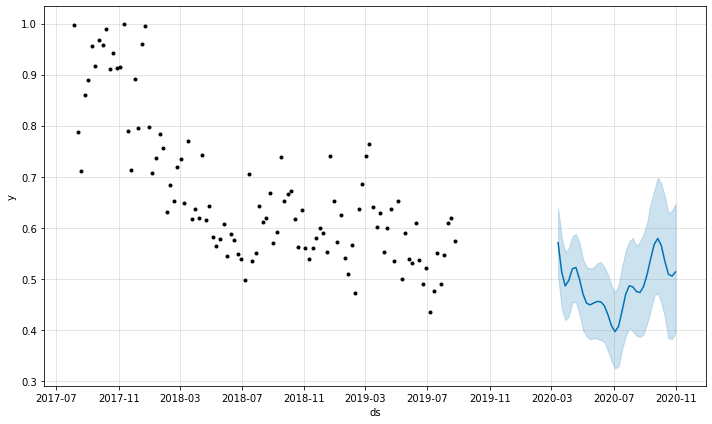

In [47]:
model = Prophet(**best_params)
model.fit(train_data)
forecast = model.predict(test_data)
fig = model.plot(forecast)
forecast

In [48]:
# metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from math import sqrt

def metrics_calulation(test_target,yhat, scale=1):
    test_target = test_target * scale
    yhat = yhat * scale
    mse = mean_squared_error(test_target, yhat)
    mae = mean_absolute_error(test_target, yhat)
    r2 = r2_score(test_target, yhat)
    medae = median_absolute_error(test_target, yhat)
    rmse = sqrt(mse)
    print(f"Mean Squared Error: {mse}\nMean Absolute Error: {mae}\nR2 Score: {r2}\nMedian Absolute Error: {medae}\nRoot Mean Squared Error: {rmse}")
    return {'mse':mse,'mae':mae,'r2':r2,'medae':medae,'rmse':rmse}	
# Calculate the metrics
test_target = test_data['y']
yhat = forecast['yhat']
scores = metrics_calulation(test_target,yhat, scale=1)
scores

Mean Squared Error: 0.03256717971935059
Mean Absolute Error: 0.16106222693119113
R2 Score: -3.879469076198233
Median Absolute Error: 0.17148470169131425
Root Mean Squared Error: 0.18046379060451598


{'mse': 0.03256717971935059,
 'mae': 0.16106222693119113,
 'r2': -3.879469076198233,
 'medae': 0.17148470169131425,
 'rmse': 0.18046379060451598}

Non Tuned

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-03-14,0.603339,0.575441,0.718326,0.603320,0.603368,0.044619,0.044619,0.044619,0.044619,0.044619,0.044619,0.0,0.0,0.0,0.647959
1,2020-03-21,0.603589,0.519630,0.669573,0.603435,0.603753,-0.012161,-0.012161,-0.012161,-0.012161,-0.012161,-0.012161,0.0,0.0,0.0,0.591428
2,2020-03-28,0.603839,0.491788,0.637806,0.603476,0.604243,-0.039250,-0.039250,-0.039250,-0.039250,-0.039250,-0.039250,0.0,0.0,0.0,0.564589
3,2020-04-04,0.604089,0.502310,0.653293,0.603449,0.604791,-0.026755,-0.026755,-0.026755,-0.026755,-0.026755,-0.026755,0.0,0.0,0.0,0.577334
4,2020-04-11,0.604339,0.527413,0.676379,0.603382,0.605345,-0.002316,-0.002316,-0.002316,-0.002316,-0.002316,-0.002316,0.0,0.0,0.0,0.602023
5,2020-04-18,0.604589,0.531732,0.682002,0.603274,0.605982,0.002273,0.002273,0.002273,0.002273,0.002273,0.002273,0.0,0.0,0.0,0.606862
6,2020-04-25,0.604838,0.509324,0.661548,0.603249,0.606623,-0.018751,-0.018751,-0.018751,-0.018751,-0.018751,-0.018751,0.0,0.0,0.0,0.586088
7,2020-05-02,0.605088,0.480976,0.629331,0.603138,0.607361,-0.046869,-0.046869,-0.046869,-0.046869,-0.046869,-0.046869,0.0,0.0,0.0,0.558219
8,2020-05-09,0.605338,0.465057,0.613889,0.603014,0.608081,-0.063155,-0.063155,-0.063155,-0.063155,-0.063155,-0.063155,0.0,0.0,0.0,0.542183
9,2020-05-16,0.605588,0.468326,0.619738,0.602682,0.608821,-0.064528,-0.064528,-0.064528,-0.064528,-0.064528,-0.064528,0.0,0.0,0.0,0.541059


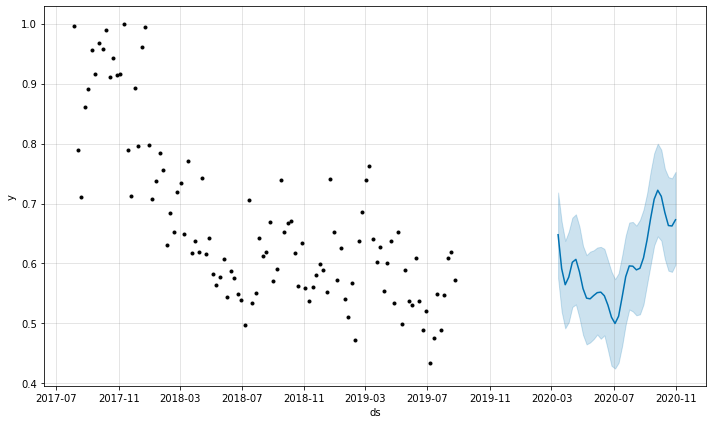

In [52]:
model = Prophet()
model.fit(train_data)
forecast = model.predict(test_data)
fig = model.plot(forecast)
forecast

In [53]:
test_target = test_data['y']
yhat = forecast['yhat']
scores = metrics_calulation(test_target,yhat, scale=1)
scores

Mean Squared Error: 0.0803022412320127
Mean Absolute Error: 0.2680371620895321
R2 Score: -11.031508599075893
Median Absolute Error: 0.2855480194059188
Root Mean Squared Error: 0.28337650084651106


{'mse': 0.0803022412320127,
 'mae': 0.2680371620895321,
 'r2': -11.031508599075893,
 'medae': 0.2855480194059188,
 'rmse': 0.28337650084651106}